# Day 5 Image Filters 

Inspirtation: https://www.youtube.com/watch?v=pZATswy_IsQ


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from pathlib import Path
import skimage.io
from skimage import img_as_float, exposure

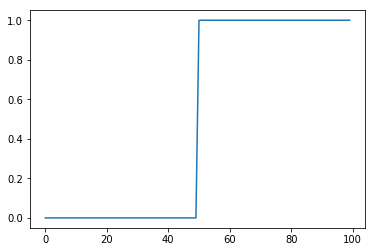

In [2]:
step_signal = np.zeros(100)
step_signal[50:] = 1; plt.plot(step_signal);

**Exercise:** Can you predict what a convolution with the kernel `[-1,0,1]` does? Try thinking about it before running the cells below.

`[1,1,1,1,0,0,0,0]` would result in `[0,0,0,-1,-1,0,0,0]`

The section here `[1,1,0]` x the kernel `[-1,0,1]` = 1 x -1 + 1 x 0 + 0 x 1 = -1 

etc. 

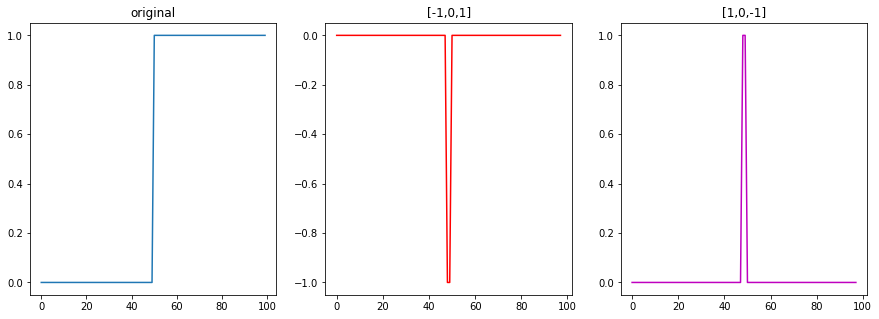

In [3]:
result = np.convolve(a=step_signal, v=np.array([-1,0,1]), mode='valid')
result2 = np.convolve(a=step_signal, v=np.array([1,0,-1]), mode='valid')
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].plot(step_signal);ax[0].set_title('original')
ax[1].plot(result,color='r');ax[1].set_title('[-1,0,1]')
ax[2].plot(result2,color='m');ax[2].set_title('[1,0,-1]');

The spike identifies an edge!

If a dataset is noisy then lots of edges will be identified, so we need to smooth the data! How did I do that yesterday? I took the average of pixels. 

Let's create the noisy data again:

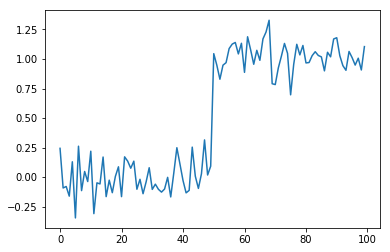

In [4]:
np.random.seed(1)
step_noisy = step_signal + np.random.normal(loc=0.0, scale=0.15, size=step_signal.shape)
plt.plot(step_noisy);

Let's find the edge of the noisy data...

1. create the de-noising Gaussian filter (width 9, center 4) with $\sigma=1$ is given by:

$$
k_i = \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{(x_i - x_0)^2}{2}\right)}
$$
2. convolve the de-noising filter with the edge detecting filter
3. now convolve it with the noisy data

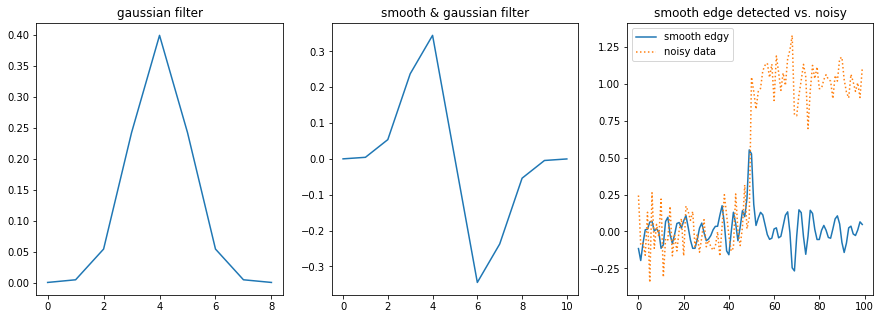

In [5]:
gaussian_filter = 1 / np.sqrt(2 * np.pi) * np.exp(-(np.arange(9) - 4) **2/2)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].plot(gaussian_filter)
ax[0].set_title('gaussian filter')
smooth_and_gaussian_filter = np.convolve(gaussian_filter, [1,0,-1], mode='full')
ax[1].plot(smooth_and_gaussian_filter)
ax[1].set_title('smooth & gaussian filter')
smooth_signal = convolve(step_noisy, smooth_and_gaussian_filter)
ax[2].plot(smooth_signal, label='smooth edgy')
ax[2].plot(step_noisy, linestyle='dotted', label='noisy data');
ax[2].set_title('smooth edge detected vs. noisy')
ax[2].legend(loc='upper left');

The biggest spike is showing the step/edge.

# Introducing 2D image filtering

In [6]:
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1; print(bright_square)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


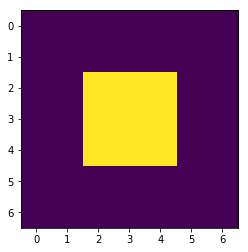

In [7]:
fig, ax = plt.subplots()
ax.imshow(bright_square);

In [8]:
#--------------------------------------------------------------------------
# Convolution Demo - taken directly from 
# https://github.com/orrbeer/https-github.com-scikit-image-skimage-tutorials
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi
from matplotlib import patches

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('cyan', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append(((i, j), (filter_overlay, filtered)))

        (i, j), images = image_cache[i_step]
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
        
        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax)
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False)
            ax.add_patch(rect)
            
        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return slices

In [9]:
mean_filter_interactive_demo(bright_square)

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

Note that all the values of the kernel sum to 1. 

### Starting to get the Madagascar satellite image ready for tomorrow

In [10]:
datapath = Path('../data')#; datapath.exists()

In [11]:
# ! gdal_merge.py -o {datapath}/madagascar_3b.tif -separate {datapath}/B04.tif {datapath}/B03.tif {datapath}/B02.tif -co PHOTOMETRIC=RGB -co COMPRESS=DEFLATE

In [12]:
image = skimage.io.imread(datapath.joinpath('madagascar_3b.tif'))

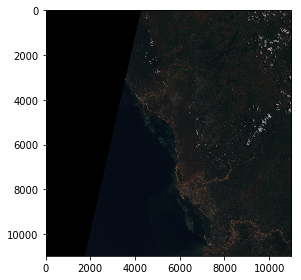

In [13]:
skimage.io.imshow(image / image.max());

source of inspiration to `/image.max()`: http://justinbois.github.io/bootcamp/2015/lessons/l34_intro_to_image_processing.html

With this division I get a warning and then what appears to be an empty picture! The warning is that we have a low dynamic range. 

To view the images in their full range, we should divide by the maximal pixel value.

.....Now to create a png to test image filtering techniques

In [14]:
! gdal_translate -of PNG {datapath}/madagascar_3b.tif {datapath}/test.png

Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.


This produces a very dark image. Pixel range is weirdly low on the 16-bit image. 

Solution: normalise and rescale!

In [15]:
image_float = img_as_float(image)
p2, p98 = np.percentile(image_float, (2, 98))
image_rescale = exposure.rescale_intensity(image_float, in_range=(p2, p98))

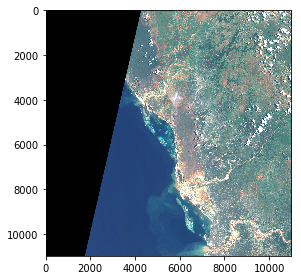

In [16]:
skimage.io.imshow(image_rescale);

In [18]:
skimage.io.imsave(datapath.joinpath('madagascar_3b.png'), image_rescale)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
